Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [88]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


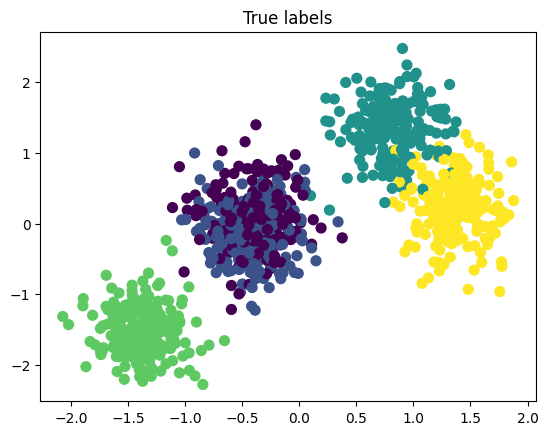

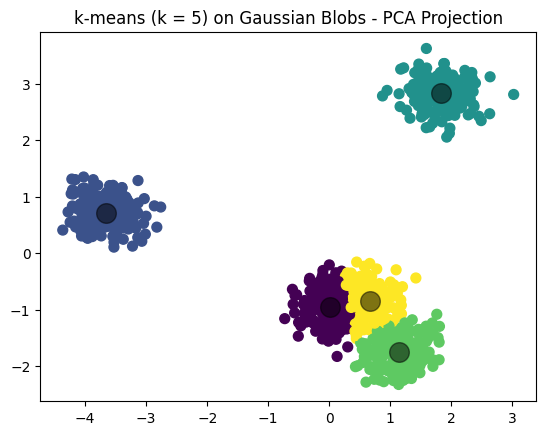

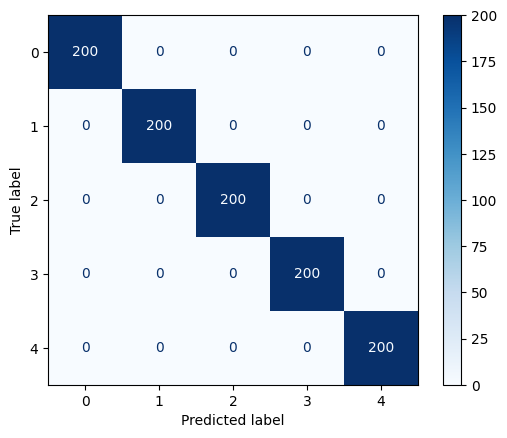

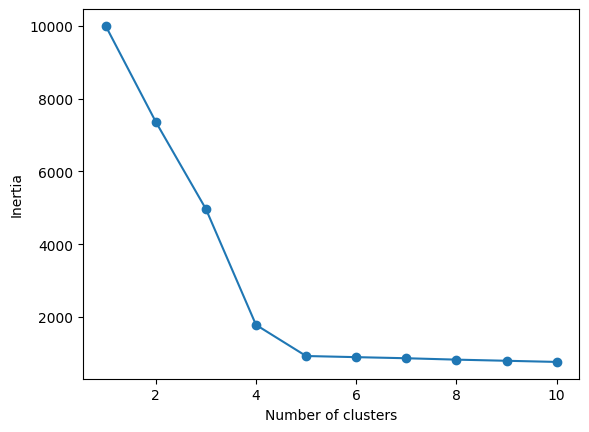

In [93]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA

#Graph of the Data
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis')
ax.set_title("True labels")
plt.show()

kmeans = KMeans(n_clusters=5, random_state=0, n_init='auto')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
cluster_centers = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_

inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    inertia.append(kmeans.inertia_)
#print("Smallest k-means Inertia Value =", min(inertia))

#PCA Visualization
pca = PCA(n_components=2) #Reduces the data to 2D so we can view it
X_pca = pca.fit_transform(X)
kmeans_pca = KMeans(n_clusters=5, random_state=0).fit(X_pca)
cluster_centers_pca = kmeans_pca.cluster_centers_
kmeans_labels_pca = kmeans_pca.labels_

plt.figure()
plt.title("k-means (k = 5) on Gaussian Blobs - PCA Projection")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels_pca, s=50, cmap='viridis')
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='black', s=200, alpha=0.5)
plt.show()

#Confusion Matrix with remapped data
cm = confusion_matrix(y_true, kmeans_labels)
row_ind, col_ind = linear_sum_assignment(-cm)
remapped_kmeans_labels = np.zeros_like(kmeans_labels)
for i in range(len(row_ind)):
    remapped_kmeans_labels[kmeans_labels == row_ind[i]] = col_ind[i]
final_cm = confusion_matrix(y_true, remapped_kmeans_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=final_cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#Elbow
plt.figure()
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In [98]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


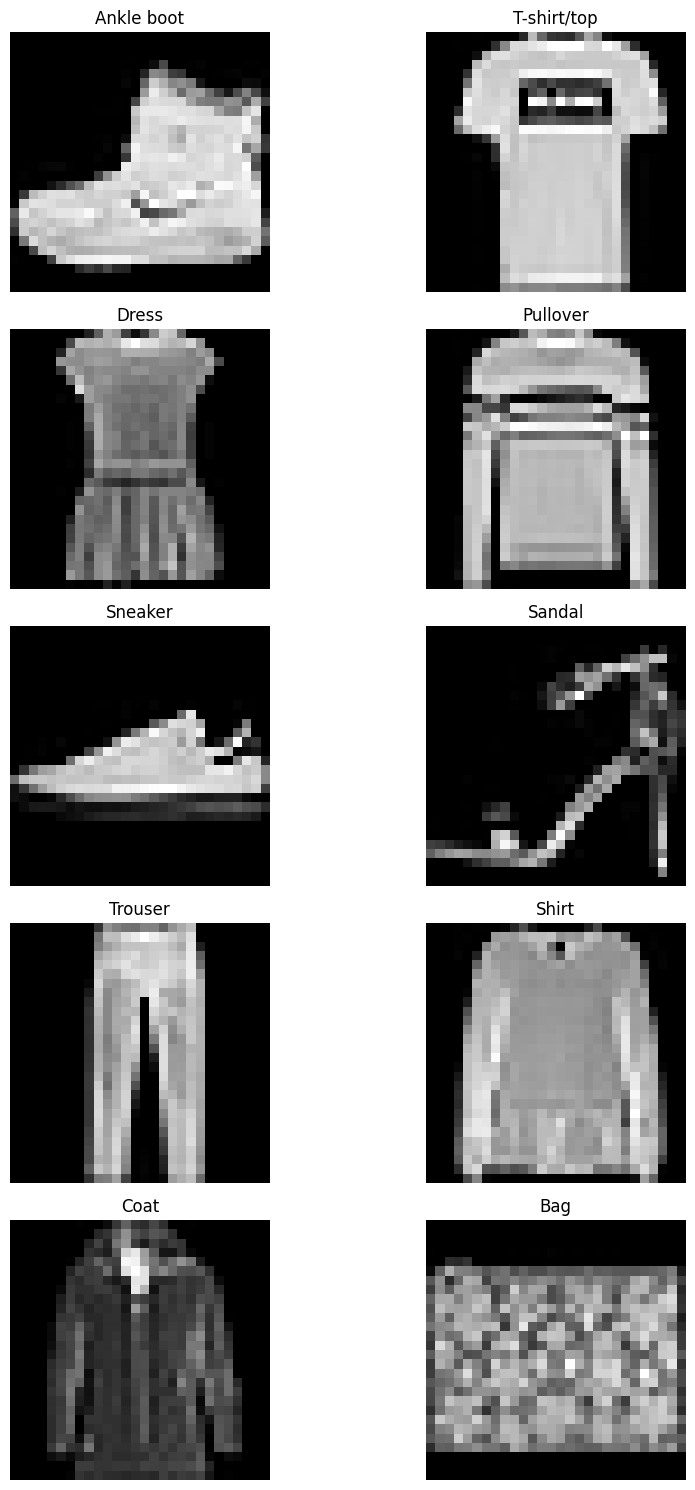

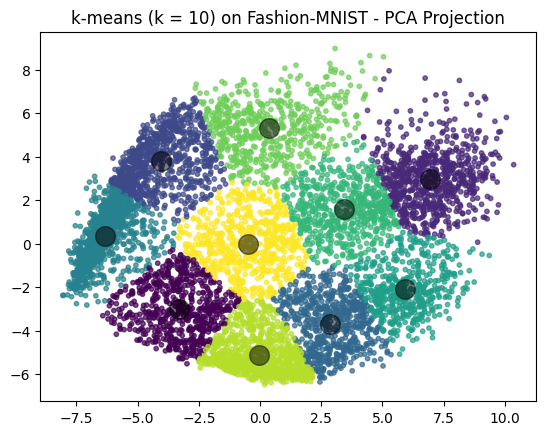

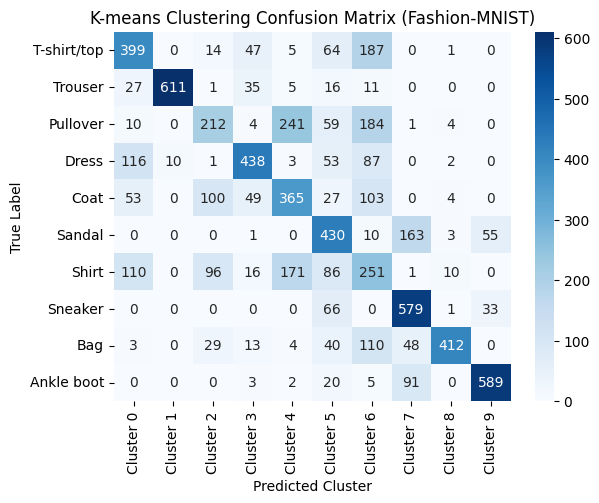

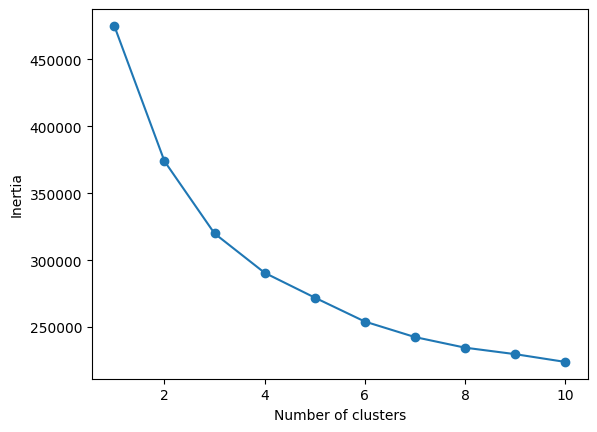

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

#Graph of the full Dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig, ax = plt.subplots(5, 2, figsize=(10, 15))
ax = ax.flatten()

display_classes = set()
i = 0
j = 0

while i < 10:
  if y[j] not in display_classes:
    ax[i].imshow(X[j].reshape(28, 28), cmap='gray')
    ax[i].set_title(class_names[int(y[j])])
    ax[i].axis('off')
    display_classes.add(y[j])
    i += 1
  j += 1

plt.tight_layout()
plt.show()

#Split the data 90/10
X_90, X_10, y_90, y_10 = train_test_split(X, y, test_size=0.1, random_state=0)

#Flatten the images
X_10_flat = X_10.reshape(X_10.shape[0], -1)

#Normalize the pixel values
X_10_normalized = X_10_flat / 255.0

n_clusters = 10

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=0,)

kmeans.fit(X_10_normalized)
kmeans_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

pca = PCA(n_components=2) #Reduces the data to 2D so we can view it
X_pca = pca.fit_transform(X_10_normalized)
kmeans_pca = KMeans(n_clusters=10, random_state=0).fit(X_pca)
cluster_centers_pca = kmeans_pca.cluster_centers_
kmeans_labels_pca = kmeans_pca.labels_

plt.figure()
plt.title("k-means (k = 10) on Fashion-MNIST - PCA Projection")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels_pca, cmap='viridis', s=10, alpha=0.7)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='black', s=200, alpha=0.5)
plt.show()

#Label mapping function
def find_label_mapping(y_true, y_pred, n_clusters):
    contingency_matrix = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    mapping = {cluster_id: true_label for cluster_id, true_label in zip(col_ind, row_ind)}
    return mapping

mapping = find_label_mapping(y_10, kmeans_labels, n_clusters)
kmeans_labels_mapped = np.array([mapping[label] for label in kmeans_labels])

#Plot the confusion matrix
cm = confusion_matrix(y_10, kmeans_labels_mapped)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Cluster {i}" for i in range(n_clusters)],
            yticklabels=[
                'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
            ])
plt.title('K-means Clustering Confusion Matrix (Fashion-MNIST)')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()

#Elbow
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_10_normalized)
    inertia.append(kmeans.inertia_)
#print("Smallest k-means Inertia Value =", min(inertia))

plt.figure()
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

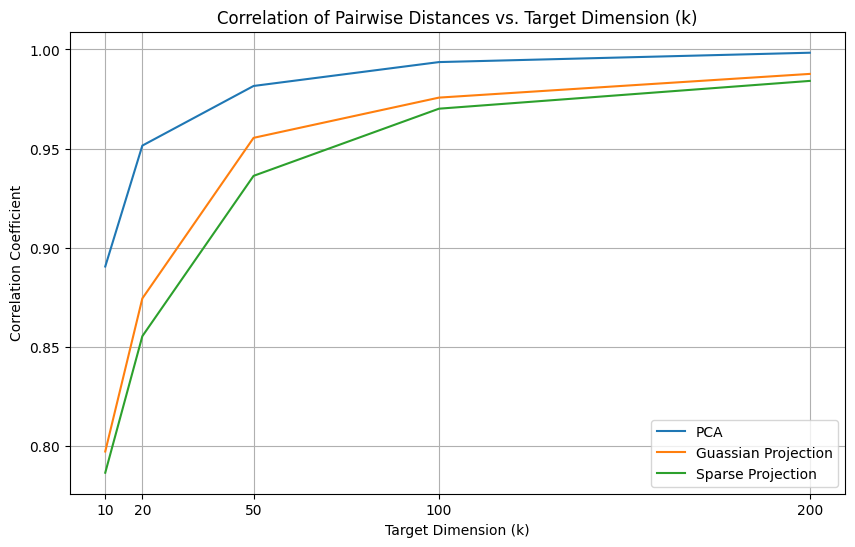

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

#Split the data 90/10
X_90, X_10, y_90, y_10 = train_test_split(X, y, test_size=0.1, random_state=0)

#Preprocessing
X_p = X_10 / 255.0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_p)

#Compute pairwise distances in the original standardized space
original_distances = pdist(X_scaled)

#Target dimensions
k_values = [10, 20, 50, 100, 200]

pca_correlations = []
rp_correlations = []
sp_correlations = []

for k in k_values:
    #PCA
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)
    pca_distances = pdist(X_pca)
    pca_correlation = np.corrcoef(original_distances, pca_distances)[0, 1]
    pca_correlations.append(pca_correlation)

    #Guassian Projection
    rp = GaussianRandomProjection(n_components=k, random_state=0)
    X_rp = rp.fit_transform(X_scaled)
    rp_distances = pdist(X_rp)
    rp_correlation = np.corrcoef(original_distances, rp_distances)[0, 1]
    rp_correlations.append(rp_correlation)

    #Sparce Projection
    sp = SparseRandomProjection(n_components=k, random_state=0)
    X_sp = sp.fit_transform(X_scaled)
    sp_distances = pdist(X_sp)
    sp_correlation = np.corrcoef(original_distances, sp_distances)[0, 1]
    sp_correlations.append(sp_correlation)

#Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, pca_correlations, label='PCA')
plt.plot(k_values, rp_correlations, label='Guassian Projection')
plt.plot(k_values, sp_correlations, label='Sparse Projection')
plt.title('Correlation of Pairwise Distances vs. Target Dimension (k)')
plt.xlabel('Target Dimension (k)')
plt.ylabel('Correlation Coefficient')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()



# 4. Clustering Fashion-MNIST using spectral clustering

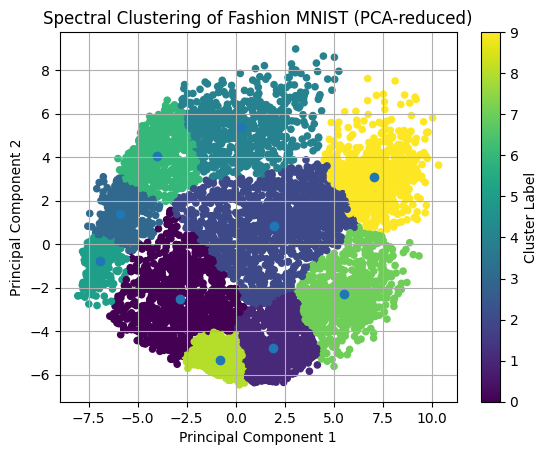

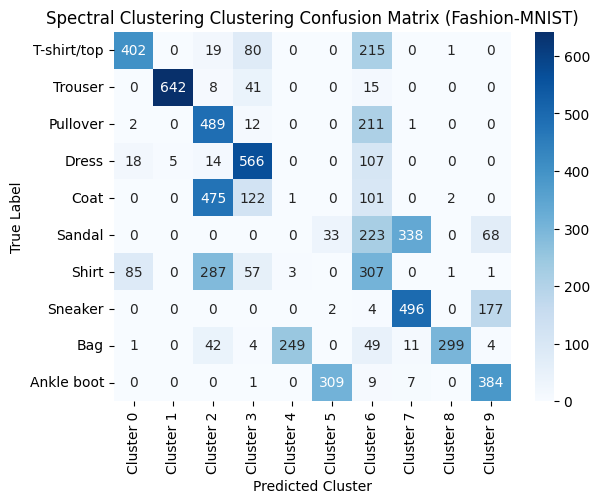

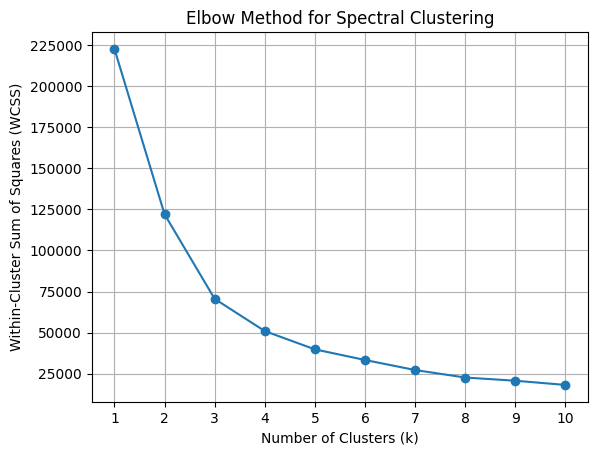

In [84]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.metrics import adjusted_rand_score, v_measure_score
import matplotlib.pyplot as plt
import seaborn as sns

#Split the data 90/10
X_90, X_10, y_90, y_10 = train_test_split(X, y, test_size=0.1, random_state=0)

#Flatten the images
X_10_flat = X_10.reshape(X_10.shape[0], -1)

#Normalize the pixel values
X_10_normalized = X_10_flat / 255.0

#There are 10 clusters in the data
n_clusters = 10

#Clustering
spectral_clustering = SpectralClustering(
    n_clusters=n_clusters,
    affinity='nearest_neighbors',
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=0,
    n_init=10)

spectral_clustering.fit(X_10_normalized)
spectral_clustering_labels = spectral_clustering.labels_

#Reduce to 2 components for plotting
pca = PCA(n_components=2)
X_10_normalized_reduced = pca.fit_transform(X_10_normalized)

#Fit the model and get cluster labels
labels_reduced = spectral_clustering.fit_predict(X_10_normalized_reduced)

cluster_centers = []
for i in range(n_clusters):
    cluster_points = X_pca[labels_reduced == i]
    if len(cluster_points) > 0: #Check if cluster is not empty
        cluster_centers.append(np.mean(cluster_points, axis=0))
    else:
        cluster_centers.append(np.array([np.nan, np.nan])) #Handle empty clusters
cluster_centers = np.array(cluster_centers)

#Scatter Plot
plt.figure()
scatter = plt.scatter(X_10_normalized_reduced[:, 0], X_10_normalized_reduced[:, 1], c=labels_reduced, cmap='viridis', s=20)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],)
plt.title('Spectral Clustering of Fashion MNIST (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

#Label mapping function
def find_label_mapping(y_true, y_pred, n_clusters):
    contingency_matrix = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    mapping = {cluster_id: true_label for cluster_id, true_label in zip(col_ind, row_ind)}
    return mapping

mapping = find_label_mapping(y_10, spectral_clustering_labels, n_clusters)
spectral_clustering_labels_mapped = np.array([mapping[label] for label in spectral_clustering_labels])

#Plot the confusion matrix
cm = confusion_matrix(y_10, spectral_clustering_labels_mapped)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Cluster {i}" for i in range(n_clusters)],
            yticklabels=[
                'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
            ])
plt.title('Spectral Clustering Clustering Confusion Matrix (Fashion-MNIST)')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.show()

#Elbow
wcss = []
k_range = range(1, 11)

#There is no way to directly pull inertia so we will compute it here
for k in k_range:
    spectral_k = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                    n_neighbors=10, assign_labels='kmeans', random_state=0)
    labels_k = spectral_k.fit_predict(X_10_normalized_reduced)

    kmeans_wcss = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans_wcss.fit(X_10_normalized_reduced)
    wcss.append(kmeans_wcss.inertia_)

plt.figure()
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Spectral Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()